In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
def make_train_test(data, test_size=0.3):
    sbd = data[data['sbj'] == 1]
    X_train, X_test, y1, y2 = train_test_split(sbd, sbd, test_size=test_size)
    for i in range(2, data.sbj.max()+1):
        sbd = data[data['sbj'] == i]
        tr, ts, y1, y2 = train_test_split(sbd, sbd, test_size=test_size)
        X_train = pd.concat([X_train, tr])
        X_test = pd.concat([X_test, ts])
        
    return X_train.reset_index(drop=True), X_test.reset_index(drop=True)

In [3]:
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[1]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [4]:
data_df = pd.read_csv('_data/Kr2010.csv', index_col=0)

# data_df = data_df[data_df['sbj']<11]

min_rt = data_df.groupby(by='sbj')['rt'].min()

In [5]:
tr_df, ts_df = make_train_test(data_df, test_size=0.3)

obs_train = np.asarray(tr_df[['rt', 'Right']])
X_train = np.asarray(tr_df[['item_value_1', 'item_value_2', 'gaze_1', 'gaze_2']])

obs_test = np.asarray(ts_df[['rt', 'Right']])
X_test = np.asarray(ts_df[['item_value_1', 'item_value_2', 'gaze_1', 'gaze_2']])

print(X_train.shape, X_test.shape)

(2448, 4) (1074, 4)


In [6]:
def fpt(t, b, v):
    return b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))

def G2(data, pred):
    ndt = tf.convert_to_tensor([min_rt[i]*tf.math.sigmoid(model.layers[-1].weights[-1][i-1]) for i in tr_df['sbj']])
    thr = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-2][i-1])) for i in tr_df['sbj']])
    scl = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-3][i-1])) for i in tr_df['sbj']])
    
    ll1 = (1 - obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]))
    
    return -2*tf.reduce_sum(tf.math.log(ll1 + ll2), axis=-1)

In [7]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [8]:
layers_neuron = [10, 10, 8, 5]
input_shape = 4
output_shape = 2
activation = 'tanh'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dense_3 (Dense)             (None, 5)                 45        
                                                                 
 out_layer (Out_layer)       (None, 2)                 129       
                                                                 
Total params: 422 (1.65 KB)
Trainable params: 422 (1.65 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [9]:
history = model.fit(X_train, obs_train, shuffle=False, batch_size=X_train.shape[0], epochs=4000)

Epoch 1/4000
1/1 [==============================] - 60s 60s/step - loss: 14872.7988
Epoch 2/4000
1/1 [==============================] - 0s 24ms/step - loss: 14807.4785
Epoch 3/4000
1/1 [==============================] - 0s 17ms/step - loss: 14759.4463
Epoch 4/4000
1/1 [==============================] - 0s 16ms/step - loss: 14718.8037
Epoch 5/4000
1/1 [==============================] - 0s 17ms/step - loss: 14682.4121
Epoch 6/4000
1/1 [==============================] - 0s 16ms/step - loss: 14648.8369
Epoch 7/4000
1/1 [==============================] - 0s 16ms/step - loss: 14617.2812
Epoch 8/4000
1/1 [==============================] - 0s 16ms/step - loss: 14587.2529
Epoch 9/4000
1/1 [==============================] - 0s 16ms/step - loss: 14558.4180
Epoch 10/4000
1/1 [==============================] - 0s 17ms/step - loss: 14530.5264
Epoch 11/4000
1/1 [==============================] - 0s 20ms/step - loss: 14503.3936
Epoch 12/4000
1/1 [==============================] - 0s 16ms/step - loss: 

1/1 [==============================] - 0s 24ms/step - loss: 12054.1738
Epoch 193/4000
1/1 [==============================] - 0s 23ms/step - loss: 12046.5020
Epoch 194/4000
1/1 [==============================] - 0s 25ms/step - loss: 12038.8584
Epoch 195/4000
1/1 [==============================] - 0s 27ms/step - loss: 12031.2451
Epoch 196/4000
1/1 [==============================] - 0s 28ms/step - loss: 12023.6621
Epoch 197/4000
1/1 [==============================] - 0s 24ms/step - loss: 12016.1094
Epoch 198/4000
1/1 [==============================] - 0s 23ms/step - loss: 12008.5840
Epoch 199/4000
1/1 [==============================] - 0s 23ms/step - loss: 12001.0879
Epoch 200/4000
1/1 [==============================] - 0s 23ms/step - loss: 11993.6201
Epoch 201/4000
1/1 [==============================] - 0s 23ms/step - loss: 11986.1816
Epoch 202/4000
1/1 [==============================] - 0s 23ms/step - loss: 11978.7715
Epoch 203/4000
1/1 [==============================] - 0s 23ms/step - 

1/1 [==============================] - 0s 23ms/step - loss: 10936.0547
Epoch 383/4000
1/1 [==============================] - 0s 23ms/step - loss: 10931.1514
Epoch 384/4000
1/1 [==============================] - 0s 24ms/step - loss: 10926.2539
Epoch 385/4000
1/1 [==============================] - 0s 23ms/step - loss: 10921.3604
Epoch 386/4000
1/1 [==============================] - 0s 23ms/step - loss: 10916.4707
Epoch 387/4000
1/1 [==============================] - 0s 23ms/step - loss: 10911.5840
Epoch 388/4000
1/1 [==============================] - 0s 23ms/step - loss: 10906.7031
Epoch 389/4000
1/1 [==============================] - 0s 23ms/step - loss: 10901.8232
Epoch 390/4000
1/1 [==============================] - 0s 23ms/step - loss: 10896.9473
Epoch 391/4000
1/1 [==============================] - 0s 23ms/step - loss: 10892.0762
Epoch 392/4000
1/1 [==============================] - 0s 24ms/step - loss: 10887.2070
Epoch 393/4000
1/1 [==============================] - 0s 23ms/step - 

1/1 [==============================] - 0s 23ms/step - loss: 9889.3516
Epoch 573/4000
1/1 [==============================] - 0s 23ms/step - loss: 9883.7910
Epoch 574/4000
1/1 [==============================] - 0s 23ms/step - loss: 9878.2402
Epoch 575/4000
1/1 [==============================] - 0s 23ms/step - loss: 9872.6875
Epoch 576/4000
1/1 [==============================] - 0s 23ms/step - loss: 9867.1445
Epoch 577/4000
1/1 [==============================] - 0s 23ms/step - loss: 9861.6016
Epoch 578/4000
1/1 [==============================] - 0s 23ms/step - loss: 9856.0674
Epoch 579/4000
1/1 [==============================] - 0s 23ms/step - loss: 9850.5352
Epoch 580/4000
1/1 [==============================] - 0s 24ms/step - loss: 9845.0137
Epoch 581/4000
1/1 [==============================] - 0s 23ms/step - loss: 9839.4922
Epoch 582/4000
1/1 [==============================] - 0s 24ms/step - loss: 9833.9844
Epoch 583/4000
1/1 [==============================] - 0s 27ms/step - loss: 9828.

1/1 [==============================] - 0s 24ms/step - loss: 8916.0273
Epoch 765/4000
1/1 [==============================] - 0s 23ms/step - loss: 8911.1943
Epoch 766/4000
1/1 [==============================] - 0s 23ms/step - loss: 8906.3750
Epoch 767/4000
1/1 [==============================] - 0s 23ms/step - loss: 8901.5439
Epoch 768/4000
1/1 [==============================] - 0s 23ms/step - loss: 8896.7246
Epoch 769/4000
1/1 [==============================] - 0s 23ms/step - loss: 8891.8926
Epoch 770/4000
1/1 [==============================] - 0s 23ms/step - loss: 8887.0732
Epoch 771/4000
1/1 [==============================] - 0s 23ms/step - loss: 8882.2393
Epoch 772/4000
1/1 [==============================] - 0s 23ms/step - loss: 8877.4199
Epoch 773/4000
1/1 [==============================] - 0s 23ms/step - loss: 8872.5859
Epoch 774/4000
1/1 [==============================] - 0s 23ms/step - loss: 8867.7656
Epoch 775/4000
1/1 [==============================] - 0s 23ms/step - loss: 8862.

1/1 [==============================] - 0s 23ms/step - loss: 7898.2988
Epoch 957/4000
1/1 [==============================] - 0s 23ms/step - loss: 7893.5840
Epoch 958/4000
1/1 [==============================] - 0s 23ms/step - loss: 7888.9248
Epoch 959/4000
1/1 [==============================] - 0s 23ms/step - loss: 7884.2661
Epoch 960/4000
1/1 [==============================] - 0s 23ms/step - loss: 7879.6616
Epoch 961/4000
1/1 [==============================] - 0s 23ms/step - loss: 7875.0532
Epoch 962/4000
1/1 [==============================] - 0s 23ms/step - loss: 7870.4951
Epoch 963/4000
1/1 [==============================] - 0s 23ms/step - loss: 7865.9282
Epoch 964/4000
1/1 [==============================] - 0s 23ms/step - loss: 7861.4087
Epoch 965/4000
1/1 [==============================] - 0s 23ms/step - loss: 7856.8716
Epoch 966/4000
1/1 [==============================] - 0s 23ms/step - loss: 7852.3789
Epoch 967/4000
1/1 [==============================] - 0s 23ms/step - loss: 7847.

Epoch 1052/4000
1/1 [==============================] - 0s 23ms/step - loss: 7530.7124
Epoch 1053/4000
1/1 [==============================] - 0s 23ms/step - loss: 7527.7534
Epoch 1054/4000
1/1 [==============================] - 0s 23ms/step - loss: 7524.8242
Epoch 1055/4000
1/1 [==============================] - 0s 23ms/step - loss: 7521.8887
Epoch 1056/4000
1/1 [==============================] - 0s 23ms/step - loss: 7518.9814
Epoch 1057/4000
1/1 [==============================] - 0s 23ms/step - loss: 7516.0669
Epoch 1058/4000
1/1 [==============================] - 0s 23ms/step - loss: 7513.1812
Epoch 1059/4000
1/1 [==============================] - 0s 24ms/step - loss: 7510.2891
Epoch 1060/4000
1/1 [==============================] - 0s 24ms/step - loss: 7507.4238
Epoch 1061/4000
1/1 [==============================] - 0s 25ms/step - loss: 7504.5537
Epoch 1062/4000
1/1 [==============================] - 0s 25ms/step - loss: 7501.7085
Epoch 1063/4000
1/1 [==============================] -

1/1 [==============================] - 0s 23ms/step - loss: 7118.7607
Epoch 1243/4000
1/1 [==============================] - 0s 23ms/step - loss: 7117.1709
Epoch 1244/4000
1/1 [==============================] - 0s 23ms/step - loss: 7115.5713
Epoch 1245/4000
1/1 [==============================] - 0s 23ms/step - loss: 7113.9863
Epoch 1246/4000
1/1 [==============================] - 0s 23ms/step - loss: 7112.3896
Epoch 1247/4000
1/1 [==============================] - 0s 23ms/step - loss: 7110.8105
Epoch 1248/4000
1/1 [==============================] - 0s 23ms/step - loss: 7109.2163
Epoch 1249/4000
1/1 [==============================] - 0s 23ms/step - loss: 7107.6421
Epoch 1250/4000
1/1 [==============================] - 0s 23ms/step - loss: 7106.0522
Epoch 1251/4000
1/1 [==============================] - 0s 23ms/step - loss: 7104.4683
Epoch 1252/4000
1/1 [==============================] - 0s 23ms/step - loss: 7102.8882
Epoch 1253/4000
1/1 [==============================] - 0s 23ms/step - 

1/1 [==============================] - 0s 23ms/step - loss: 6889.8267
Epoch 1433/4000
1/1 [==============================] - 0s 23ms/step - loss: 6889.0439
Epoch 1434/4000
1/1 [==============================] - 0s 23ms/step - loss: 6888.2148
Epoch 1435/4000
1/1 [==============================] - 0s 24ms/step - loss: 6887.4062
Epoch 1436/4000
1/1 [==============================] - 0s 23ms/step - loss: 6886.6235
Epoch 1437/4000
1/1 [==============================] - 0s 23ms/step - loss: 6885.7534
Epoch 1438/4000
1/1 [==============================] - 0s 23ms/step - loss: 6884.9634
Epoch 1439/4000
1/1 [==============================] - 0s 22ms/step - loss: 6884.2114
Epoch 1440/4000
1/1 [==============================] - 0s 23ms/step - loss: 6883.3989
Epoch 1441/4000
1/1 [==============================] - 0s 23ms/step - loss: 6882.6167
Epoch 1442/4000
1/1 [==============================] - 0s 24ms/step - loss: 6881.8218
Epoch 1443/4000
1/1 [==============================] - 0s 24ms/step - 

1/1 [==============================] - 0s 24ms/step - loss: 6773.6362
Epoch 1623/4000
1/1 [==============================] - 0s 23ms/step - loss: 6773.0439
Epoch 1624/4000
1/1 [==============================] - 0s 24ms/step - loss: 6772.5669
Epoch 1625/4000
1/1 [==============================] - 0s 23ms/step - loss: 6772.2480
Epoch 1626/4000
1/1 [==============================] - 0s 23ms/step - loss: 6771.8018
Epoch 1627/4000
1/1 [==============================] - 0s 23ms/step - loss: 6771.2432
Epoch 1628/4000
1/1 [==============================] - 0s 23ms/step - loss: 6770.8662
Epoch 1629/4000
1/1 [==============================] - 0s 23ms/step - loss: 6770.6694
Epoch 1630/4000
1/1 [==============================] - 0s 23ms/step - loss: 6770.1855
Epoch 1631/4000
1/1 [==============================] - 0s 23ms/step - loss: 6769.2637
Epoch 1632/4000
1/1 [==============================] - 0s 23ms/step - loss: 6769.0254
Epoch 1633/4000
1/1 [==============================] - 0s 24ms/step - 

1/1 [==============================] - 0s 24ms/step - loss: 6702.4863
Epoch 1813/4000
1/1 [==============================] - 0s 23ms/step - loss: 6703.1948
Epoch 1814/4000
1/1 [==============================] - 0s 24ms/step - loss: 6702.2832
Epoch 1815/4000
1/1 [==============================] - 0s 23ms/step - loss: 6704.2217
Epoch 1816/4000
1/1 [==============================] - 0s 25ms/step - loss: 6704.3335
Epoch 1817/4000
1/1 [==============================] - 0s 23ms/step - loss: 6702.7617
Epoch 1818/4000
1/1 [==============================] - 0s 23ms/step - loss: 6701.6377
Epoch 1819/4000
1/1 [==============================] - 0s 24ms/step - loss: 6701.6055
Epoch 1820/4000
1/1 [==============================] - 0s 23ms/step - loss: 6700.7246
Epoch 1821/4000
1/1 [==============================] - 0s 24ms/step - loss: 6700.5742
Epoch 1822/4000
1/1 [==============================] - 0s 25ms/step - loss: 6700.3193
Epoch 1823/4000
1/1 [==============================] - 0s 24ms/step - 

1/1 [==============================] - 0s 25ms/step - loss: 6651.7920
Epoch 2003/4000
1/1 [==============================] - 0s 24ms/step - loss: 6651.4277
Epoch 2004/4000
1/1 [==============================] - 0s 23ms/step - loss: 6654.1885
Epoch 2005/4000
1/1 [==============================] - 0s 23ms/step - loss: 6651.2358
Epoch 2006/4000
1/1 [==============================] - 0s 24ms/step - loss: 6649.8086
Epoch 2007/4000
1/1 [==============================] - 0s 24ms/step - loss: 6649.7764
Epoch 2008/4000
1/1 [==============================] - 0s 23ms/step - loss: 6650.2900
Epoch 2009/4000
1/1 [==============================] - 0s 24ms/step - loss: 6650.6533
Epoch 2010/4000
1/1 [==============================] - 0s 23ms/step - loss: 6650.4336
Epoch 2011/4000
1/1 [==============================] - 0s 23ms/step - loss: 6652.4653
Epoch 2012/4000
1/1 [==============================] - 0s 23ms/step - loss: 6651.1045
Epoch 2013/4000
1/1 [==============================] - 0s 24ms/step - 

1/1 [==============================] - 0s 26ms/step - loss: 6619.3311
Epoch 2194/4000
1/1 [==============================] - 0s 23ms/step - loss: 6615.6841
Epoch 2195/4000
1/1 [==============================] - 0s 24ms/step - loss: 6614.1543
Epoch 2196/4000
1/1 [==============================] - 0s 24ms/step - loss: 6614.9248
Epoch 2197/4000
1/1 [==============================] - 0s 24ms/step - loss: 6611.8594
Epoch 2198/4000
1/1 [==============================] - 0s 23ms/step - loss: 6614.6802
Epoch 2199/4000
1/1 [==============================] - 0s 24ms/step - loss: 6610.5635
Epoch 2200/4000
1/1 [==============================] - 0s 24ms/step - loss: 6609.4458
Epoch 2201/4000
1/1 [==============================] - 0s 23ms/step - loss: 6608.6724
Epoch 2202/4000
1/1 [==============================] - 0s 24ms/step - loss: 6614.5522
Epoch 2203/4000
1/1 [==============================] - 0s 24ms/step - loss: 6609.6343
Epoch 2204/4000
1/1 [==============================] - 0s 24ms/step - 

1/1 [==============================] - 0s 24ms/step - loss: 6583.7329
Epoch 2384/4000
1/1 [==============================] - 0s 24ms/step - loss: 6583.3779
Epoch 2385/4000
1/1 [==============================] - 0s 24ms/step - loss: 6586.1685
Epoch 2386/4000
1/1 [==============================] - 0s 27ms/step - loss: 6585.1118
Epoch 2387/4000
1/1 [==============================] - 0s 27ms/step - loss: 6583.0044
Epoch 2388/4000
1/1 [==============================] - 0s 26ms/step - loss: 6582.6855
Epoch 2389/4000
1/1 [==============================] - 0s 25ms/step - loss: 6583.2744
Epoch 2390/4000
1/1 [==============================] - 0s 25ms/step - loss: 6581.3647
Epoch 2391/4000
1/1 [==============================] - 0s 25ms/step - loss: 6581.6621
Epoch 2392/4000
1/1 [==============================] - 0s 26ms/step - loss: 6582.6191
Epoch 2393/4000
1/1 [==============================] - 0s 24ms/step - loss: 6580.3955
Epoch 2394/4000
1/1 [==============================] - 0s 25ms/step - 

1/1 [==============================] - 0s 25ms/step - loss: 6556.8057
Epoch 2574/4000
1/1 [==============================] - 0s 24ms/step - loss: 6557.4219
Epoch 2575/4000
1/1 [==============================] - 0s 25ms/step - loss: 6557.6152
Epoch 2576/4000
1/1 [==============================] - 0s 24ms/step - loss: 6556.5693
Epoch 2577/4000
1/1 [==============================] - 0s 24ms/step - loss: 6556.6484
Epoch 2578/4000
1/1 [==============================] - 0s 23ms/step - loss: 6556.2153
Epoch 2579/4000
1/1 [==============================] - 0s 24ms/step - loss: 6557.5342
Epoch 2580/4000
1/1 [==============================] - 0s 23ms/step - loss: 6556.3564
Epoch 2581/4000
1/1 [==============================] - 0s 24ms/step - loss: 6556.6362
Epoch 2582/4000
1/1 [==============================] - 0s 24ms/step - loss: 6555.0415
Epoch 2583/4000
1/1 [==============================] - 0s 24ms/step - loss: 6556.0884
Epoch 2584/4000
1/1 [==============================] - 0s 24ms/step - 

1/1 [==============================] - 0s 24ms/step - loss: 6537.8345
Epoch 2764/4000
1/1 [==============================] - 0s 24ms/step - loss: 6539.0547
Epoch 2765/4000
1/1 [==============================] - 0s 24ms/step - loss: 6534.8477
Epoch 2766/4000
1/1 [==============================] - 0s 24ms/step - loss: 6536.1060
Epoch 2767/4000
1/1 [==============================] - 0s 24ms/step - loss: 6535.9448
Epoch 2768/4000
1/1 [==============================] - 0s 24ms/step - loss: 6535.5488
Epoch 2769/4000
1/1 [==============================] - 0s 23ms/step - loss: 6534.8193
Epoch 2770/4000
1/1 [==============================] - 0s 23ms/step - loss: 6535.3594
Epoch 2771/4000
1/1 [==============================] - 0s 24ms/step - loss: 6536.9526
Epoch 2772/4000
1/1 [==============================] - 0s 25ms/step - loss: 6535.2559
Epoch 2773/4000
1/1 [==============================] - 0s 24ms/step - loss: 6538.2144
Epoch 2774/4000
1/1 [==============================] - 0s 24ms/step - 

1/1 [==============================] - 0s 24ms/step - loss: 6518.3350
Epoch 2954/4000
1/1 [==============================] - 0s 24ms/step - loss: 6518.0684
Epoch 2955/4000
1/1 [==============================] - 0s 24ms/step - loss: 6523.7148
Epoch 2956/4000
1/1 [==============================] - 0s 24ms/step - loss: 6522.1567
Epoch 2957/4000
1/1 [==============================] - 0s 24ms/step - loss: 6517.1504
Epoch 2958/4000
1/1 [==============================] - 0s 23ms/step - loss: 6518.1519
Epoch 2959/4000
1/1 [==============================] - 0s 24ms/step - loss: 6516.6289
Epoch 2960/4000
1/1 [==============================] - 0s 24ms/step - loss: 6517.7803
Epoch 2961/4000
1/1 [==============================] - 0s 24ms/step - loss: 6517.1841
Epoch 2962/4000
1/1 [==============================] - 0s 24ms/step - loss: 6517.4268
Epoch 2963/4000
1/1 [==============================] - 0s 23ms/step - loss: 6516.6904
Epoch 2964/4000
1/1 [==============================] - 0s 24ms/step - 

1/1 [==============================] - 0s 23ms/step - loss: 6504.0576
Epoch 3144/4000
1/1 [==============================] - 0s 23ms/step - loss: 6503.1748
Epoch 3145/4000
1/1 [==============================] - 0s 24ms/step - loss: 6503.9971
Epoch 3146/4000
1/1 [==============================] - 0s 23ms/step - loss: 6503.0176
Epoch 3147/4000
1/1 [==============================] - 0s 24ms/step - loss: 6506.3203
Epoch 3148/4000
1/1 [==============================] - 0s 24ms/step - loss: 6505.8750
Epoch 3149/4000
1/1 [==============================] - 0s 28ms/step - loss: 6505.8340
Epoch 3150/4000
1/1 [==============================] - 0s 24ms/step - loss: 6504.4570
Epoch 3151/4000
1/1 [==============================] - 0s 24ms/step - loss: 6502.0000
Epoch 3152/4000
1/1 [==============================] - 0s 24ms/step - loss: 6500.9448
Epoch 3153/4000
1/1 [==============================] - 0s 23ms/step - loss: 6501.5498
Epoch 3154/4000
1/1 [==============================] - 0s 24ms/step - 

1/1 [==============================] - 0s 24ms/step - loss: 6487.1538
Epoch 3334/4000
1/1 [==============================] - 0s 23ms/step - loss: 6488.5469
Epoch 3335/4000
1/1 [==============================] - 0s 25ms/step - loss: 6485.7554
Epoch 3336/4000
1/1 [==============================] - 0s 24ms/step - loss: 6485.9473
Epoch 3337/4000
1/1 [==============================] - 0s 24ms/step - loss: 6486.2744
Epoch 3338/4000
1/1 [==============================] - 0s 23ms/step - loss: 6485.8564
Epoch 3339/4000
1/1 [==============================] - 0s 23ms/step - loss: 6484.0791
Epoch 3340/4000
1/1 [==============================] - 0s 24ms/step - loss: 6485.8057
Epoch 3341/4000
1/1 [==============================] - 0s 23ms/step - loss: 6485.3486
Epoch 3342/4000
1/1 [==============================] - 0s 24ms/step - loss: 6486.2236
Epoch 3343/4000
1/1 [==============================] - 0s 24ms/step - loss: 6488.8994
Epoch 3344/4000
1/1 [==============================] - 0s 23ms/step - 

1/1 [==============================] - 0s 23ms/step - loss: 6475.3535
Epoch 3524/4000
1/1 [==============================] - 0s 24ms/step - loss: 6473.4648
Epoch 3525/4000
1/1 [==============================] - 0s 23ms/step - loss: 6472.7314
Epoch 3526/4000
1/1 [==============================] - 0s 23ms/step - loss: 6473.9409
Epoch 3527/4000
1/1 [==============================] - 0s 23ms/step - loss: 6473.0479
Epoch 3528/4000
1/1 [==============================] - 0s 23ms/step - loss: 6474.2656
Epoch 3529/4000
1/1 [==============================] - 0s 33ms/step - loss: 6473.2920
Epoch 3530/4000
1/1 [==============================] - 0s 31ms/step - loss: 6473.7324
Epoch 3531/4000
1/1 [==============================] - 0s 24ms/step - loss: 6473.0571
Epoch 3532/4000
1/1 [==============================] - 0s 25ms/step - loss: 6472.4834
Epoch 3533/4000
1/1 [==============================] - 0s 24ms/step - loss: 6472.4019
Epoch 3534/4000
1/1 [==============================] - 0s 23ms/step - 

1/1 [==============================] - 0s 25ms/step - loss: 6459.3477
Epoch 3714/4000
1/1 [==============================] - 0s 25ms/step - loss: 6458.0269
Epoch 3715/4000
1/1 [==============================] - 0s 25ms/step - loss: 6461.1338
Epoch 3716/4000
1/1 [==============================] - 0s 24ms/step - loss: 6462.6660
Epoch 3717/4000
1/1 [==============================] - 0s 25ms/step - loss: 6465.1152
Epoch 3718/4000
1/1 [==============================] - 0s 25ms/step - loss: 6463.2969
Epoch 3719/4000
1/1 [==============================] - 0s 25ms/step - loss: 6461.9487
Epoch 3720/4000
1/1 [==============================] - 0s 24ms/step - loss: 6459.6655
Epoch 3721/4000
1/1 [==============================] - 0s 25ms/step - loss: 6459.0391
Epoch 3722/4000
1/1 [==============================] - 0s 24ms/step - loss: 6458.6299
Epoch 3723/4000
1/1 [==============================] - 0s 24ms/step - loss: 6460.0767
Epoch 3724/4000
1/1 [==============================] - 0s 24ms/step - 

1/1 [==============================] - 0s 23ms/step - loss: 6449.8193
Epoch 3905/4000
1/1 [==============================] - 0s 23ms/step - loss: 6448.8052
Epoch 3906/4000
1/1 [==============================] - 0s 28ms/step - loss: 6448.8042
Epoch 3907/4000
1/1 [==============================] - 0s 23ms/step - loss: 6450.0337
Epoch 3908/4000
1/1 [==============================] - 0s 23ms/step - loss: 6450.6138
Epoch 3909/4000
1/1 [==============================] - 0s 23ms/step - loss: nan
Epoch 3910/4000
1/1 [==============================] - 0s 24ms/step - loss: 6453.9189
Epoch 3911/4000
1/1 [==============================] - 0s 24ms/step - loss: 6447.5625
Epoch 3912/4000
1/1 [==============================] - 0s 24ms/step - loss: 6447.5615
Epoch 3913/4000
1/1 [==============================] - 0s 23ms/step - loss: 6447.1973
Epoch 3914/4000
1/1 [==============================] - 0s 23ms/step - loss: 6449.5518
Epoch 3915/4000
1/1 [==============================] - 0s 24ms/step - loss: 

In [10]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

34/34 [==============================] - 0s 321us/step


In [11]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]-1], ndt[ts_df.sbj[s]-1])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
#         if ts_df['item_value_1'][s] > ts_df['item_value_2'][s] and ch == 0:
#             pred_bhv['ch'].append(1)
#         elif ts_df['item_value_2'][s] > ts_df['item_value_1'][s] and ch == 1:
#             pred_bhv['ch'].append(1)
#         elif ts_df['item_value_2'][s] == ts_df['item_value_1'][s]:
#             pred_bhv['ch'].append(1)
#         else:
#             pred_bhv['ch'].append(0)
        
pred_bhv = pd.DataFrame(pred_bhv)

In [12]:
# high = ((ts_df['item_value_2'] >= ts_df['item_value_1']).map({True:2, 
#                                                               False:1}) == ts_df['choice']).map({True:1, 
#                                                                                                  False:0})
# high[ts_df['item_value_2'] == ts_df['item_value_1']] = 1
# ts_df['is_high'] = high 

PearsonRResult(statistic=0.9477648673479255, pvalue=5.966058360929839e-20)
0.8972548585412552
0.06133677344033758
PearsonRResult(statistic=0.571502100953709, pvalue=0.000144594382346443)
0.16390195688480202
0.008207868468376222


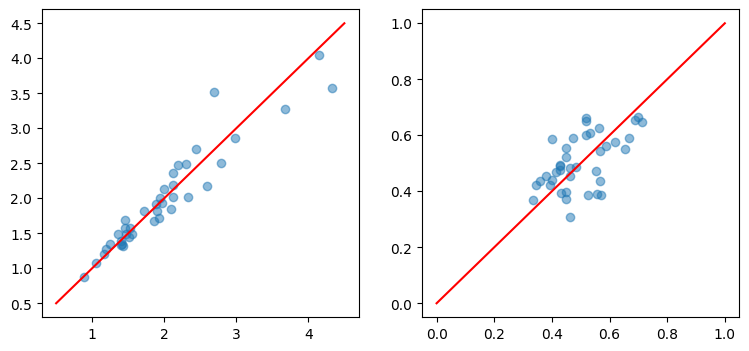

In [13]:
plt.figure(figsize=(9, 4))
plt.subplot(121)
pearsonr
print(pearsonr(ts_df.groupby(by='sbj')['rt'].mean(),
               pred_bhv.groupby(by='sbj')['rt'].mean()))
print(r2_score(ts_df.groupby(by='sbj')['rt'].mean(),
               pred_bhv.groupby(by='sbj')['rt'].mean()))
print(mean_squared_error(ts_df.groupby(by='sbj')['rt'].mean(),
               pred_bhv.groupby(by='sbj')['rt'].mean()))

plt.plot(np.linspace(0.5, 4.5, 100), np.linspace(0.5, 4.5, 100), c='red')
plt.scatter(ts_df.groupby(by='sbj')['rt'].mean(),
            pred_bhv.groupby(by='sbj')['rt'].mean(), alpha=0.5);

plt.subplot(122)
print(pearsonr(ts_df.groupby(by='sbj')['Right'].mean(),
               pred_bhv.groupby(by='sbj')['ch'].mean()))
print(r2_score(ts_df.groupby(by='sbj')['Right'].mean(),
               pred_bhv.groupby(by='sbj')['ch'].mean()))
print(mean_squared_error(ts_df.groupby(by='sbj')['Right'].mean(),
               pred_bhv.groupby(by='sbj')['ch'].mean()))

plt.plot(np.linspace(0., 1, 100), np.linspace(0., 1, 100), c='red')
plt.scatter(ts_df.groupby(by='sbj')['Right'].mean(),
            pred_bhv.groupby(by='sbj')['ch'].mean(), alpha=0.5);

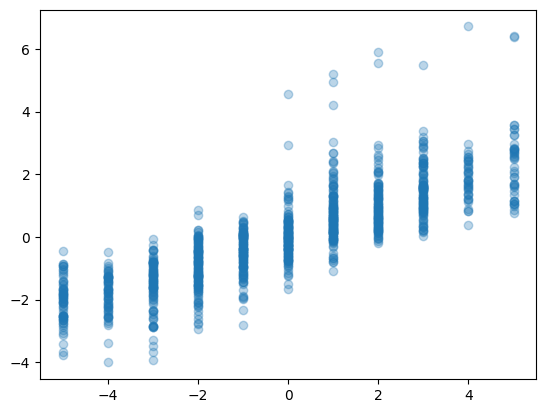

In [14]:
plt.scatter(X_test[:, 0] - X_test[:, 1], scaling*pred_v[:, 0] - scaling*pred_v[:, 1], alpha=0.3);

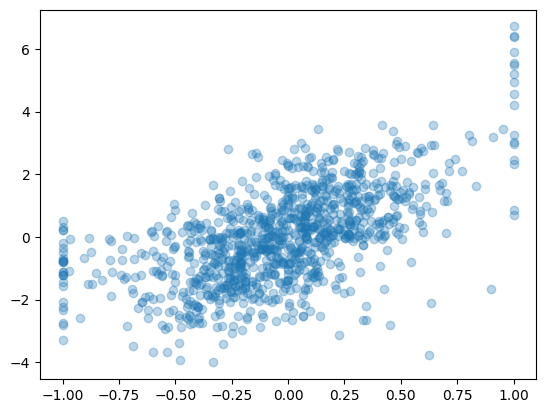

In [15]:
plt.scatter(X_test[:, 2] - X_test[:, 3], scaling*pred_v[:, 0] - scaling*pred_v[:, 1], alpha=0.3);

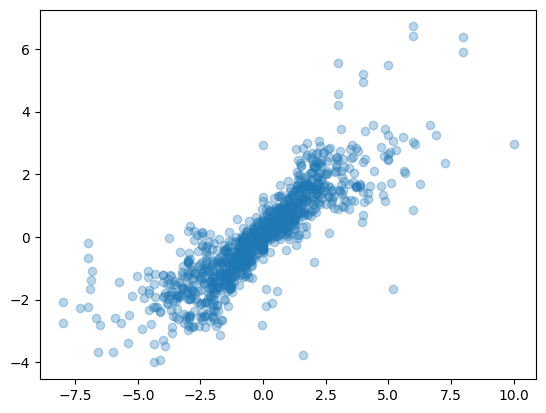

In [16]:
plt.scatter(X_test[:, 0]*X_test[:, 2] - X_test[:, 1]*X_test[:, 3], 
            scaling*pred_v[:, 0] - scaling*pred_v[:, 1], alpha=0.3);

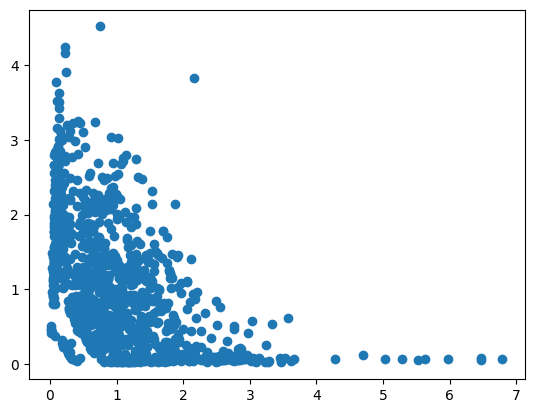

In [17]:
plt.scatter(scaling*pred_v[:, 0], scaling*pred_v[:, 1]);

In [18]:
pred_v_train = model.predict(X_train)
scaling_tr = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling_tr = np.asanyarray([scaling_tr[i-1] for i in tr_df['sbj']])

77/77 [==============================] - 0s 316us/step


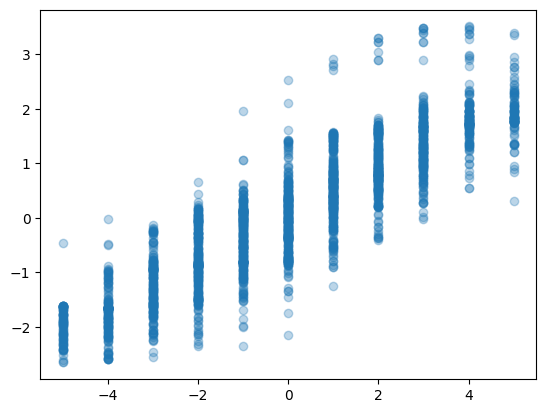

In [19]:
plt.scatter(X_train[:, 0] - X_train[:, 1], 
            pred_v_train[:, 0] - pred_v_train[:, 1], alpha=0.3);

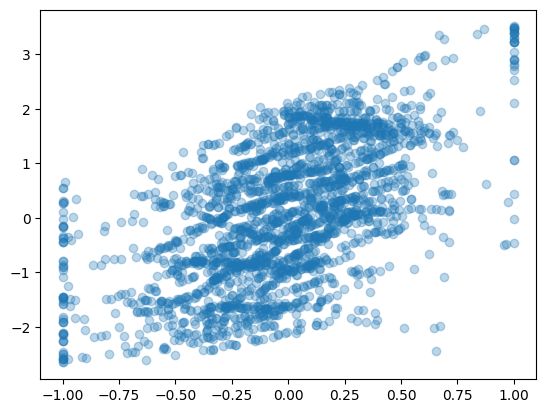

In [20]:
plt.scatter(X_train[:, 2] - X_train[:, 3], 
            pred_v_train[:, 0] - pred_v_train[:, 1], alpha=0.3);

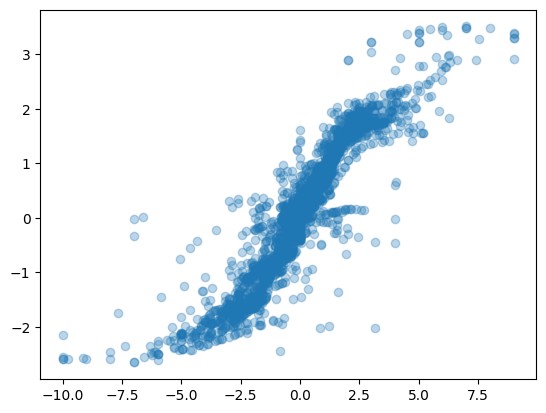

In [21]:
plt.scatter(X_train[:, 0]*X_train[:, 2] - X_train[:, 1]*X_train[:, 3], 
            pred_v_train[:, 0] - pred_v_train[:, 1], alpha=0.3);

In [22]:
# plt.scatter(X[:, 0] + X[:, 1], pred[:, 0] + pred[:, 1], alpha=0.3)
# plt.scatter(X[:, 2],  pred[:, 0], alpha=0.3);
# plt.scatter(X[:, 0]*X[:, 2],  pred[:, 0], alpha=0.3)
# plt.scatter(X[:, 0]*X[:, 2] - X[:, 1]*X[:, 3], pred[:, 0] - pred[:, 1], alpha=0.3);
# plt.scatter(X[:, 0] - X[:, 1], pred[:, 0] - pred[:, 1], alpha=0.3)
# plt.scatter(X[:, 2] - X[:, 3], pred[:, 0] - pred[:, 1], alpha=0.3)